In [1]:
!pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install -q nltk

In [3]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.sentiment import SentimentIntensityAnalyzer

from tqdm.notebook import tqdm

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from transformers import pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

import joblib

[nltk_data] Downloading package punkt to /users/gary/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /users/gary/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /users/gary/nltk_data...
/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-30 15:52:03.516058: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [224]:
df = pd.read_csv('sneakers_Reviews_Dataset.csv', sep=";")
print('Shape:', df.shape)
df.head()

Shape: (100000, 6)


,review_id,product_id,user_id,rating,review_text,timestamp
0,1,103,16074,3,"Comfortable, but not durable.",2022/11/07 05:30
1,2,436,11648,4,Highly recommend!,2021/09/11 02:53
2,3,861,46508,2,Do not recommend.,2022/12/14 13:24
3,4,271,40094,3,"Comfortable, but not durable.",2021/11/29 04:01
4,5,107,49897,4,Will buy again.,2023/04/24 12:12


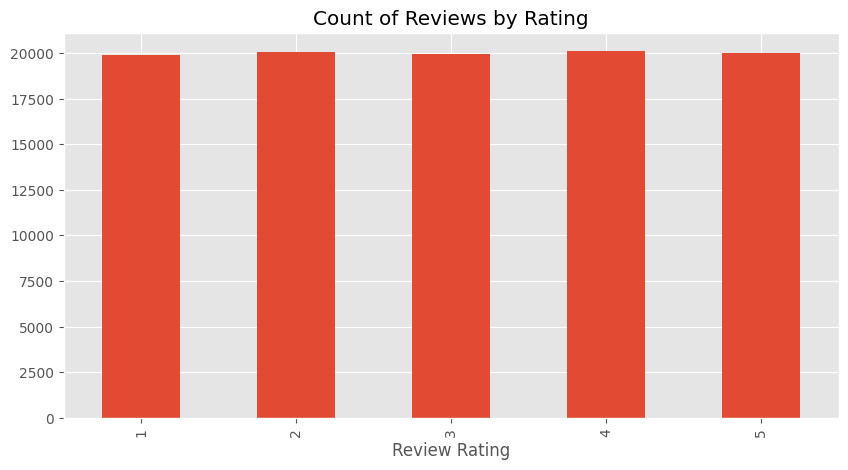

In [225]:
ax = df['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Rating',
          figsize=(10, 5))
ax.set_xlabel('Review Rating')
plt.show()

In [144]:
df['rating'].value_counts()

4    20096
2    20066
5    20006
3    19924
1    19908
Name: rating, dtype: int64

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   review_id    100000 non-null  int64 
 1   product_id   100000 non-null  int64 
 2   user_id      100000 non-null  int64 
 3   rating       100000 non-null  int64 
 4   review_text  100000 non-null  object
 5   timestamp    100000 non-null  object
dtypes: int64(4), object(2)
memory usage: 4.6+ MB


In [146]:
missing_values = df.isnull().sum()
print(missing_values)

review_id      0
product_id     0
user_id        0
rating         0
review_text    0
timestamp      0
dtype: int64


- No missing values present in the dataset and is fairly balanced as each rating has about +-20000 reviews contributing to the ratings.

In [147]:
df.describe()

,review_id,product_id,user_id,rating
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,50000.500000,500.827000,24989.389640,3.002260
std,28867.657797,288.826213,14417.825247,1.413575
min,1.000000,1.000000,1.000000,1.000000
25%,25000.750000,251.000000,12481.750000,2.000000
50%,50000.500000,501.000000,24916.000000,3.000000
75%,75000.250000,752.000000,37479.250000,4.000000
max,100000.000000,1000.000000,49998.000000,5.000000


In [148]:
df['review_text'].unique()

array(['Comfortable, but not durable.', 'Highly recommend!',
       'Do not recommend.', 'Will buy again.', 'Very uncomfortable.',
       'They are okay.', 'Poor quality!', 'I love these sneakers.',
       'Great quality!', 'Waste of money.', 'Very comfortable.',
       'Average sneakers.', 'Falling apart after a week.',
       'Decent quality.'], dtype=object)

In [149]:
df['review_text'].value_counts()

I love these sneakers.           8111
Will buy again.                  8082
Do not recommend.                8067
Falling apart after a week.      8035
Very uncomfortable.              8009
Highly recommend!                7984
Poor quality!                    7970
Great quality!                   7966
Very comfortable.                7959
Waste of money.                  7893
Average sneakers.                5078
Decent quality.                  4965
Comfortable, but not durable.    4960
They are okay.                   4921
Name: review_text, dtype: int64

### Pre-processing

In [150]:
import random
n = random.randint(0,10000)

In [151]:
ex = df['review_text'][n]
print(ex)

Very uncomfortable.


In [152]:
# convert to lowercase
ex = ex.lower()
print(ex)

very uncomfortable.


In [153]:
#remove punctuation
ex = ex.translate(str.maketrans('', '', string.punctuation))
print(ex)

very uncomfortable


In [154]:
# Tokenize example text
tokens = word_tokenize(ex)

In [155]:
print(tokens)

['very', 'uncomfortable']


In [156]:
print(stop_words)

{'few', 'for', 'whom', "that'll", 'above', 'was', 'a', 'with', "should've", 'to', 'we', "you'd", 'mustn', 'those', 'out', 'won', 'which', 'no', 'before', 'is', "mustn't", 'hers', 'own', 'his', 'm', 'himself', 'then', 'itself', 's', 'should', 'once', 'nor', 'haven', 'off', 'at', 'shouldn', 'hasn', 'themselves', 'down', "won't", 'our', 'doing', 'they', 'not', 'why', 'll', 'being', 'wouldn', 'from', 'couldn', 'didn', 'very', 'and', 'where', 'her', 'same', 'through', 'do', "you're", "doesn't", 'again', 'herself', 'each', 'my', 'but', 'further', 'an', 'its', 'yours', 'having', 'while', 'or', 'of', 'during', 'there', 'i', 'that', 'these', 'after', "aren't", "haven't", 'yourselves', "needn't", "weren't", "mightn't", "you'll", 't', 'hadn', 'were', "wasn't", 'here', 'aren', 'you', 'below', 'both', "hasn't", 'so', "couldn't", 'too', 'your', 'about', 'myself', 'isn', 'did', 'than', 'how', 'o', 'if', 'mightn', 'this', 'has', 'other', 'some', 'does', 'ours', 'theirs', 'until', 'in', 'needn', 'doesn

- Since the stop words include words such as not and don't which is present in our dataset and can be used to express a negative statement we shall not remove the stop words in hope of a more accurate trained model

In [157]:
print(tokens)

['very', 'uncomfortable']


In [158]:
#model = f"cardiffnlp/twitter-roberta-base-sentiment"
#tokenizer = AutoTokenizer.from_pretrained(model)
#sentiment = AutoModelForSequenceClassification.from_pretrained(model)

In [159]:
# Lemmatization
lemmatizer = WordNetLemmatizer()
tokens = [lemmatizer.lemmatize(word) for word in tokens]

In [160]:
print(tokens)

['very', 'uncomfortable']


In [161]:
# Join tokens back into a single string
combo = ' '.join(tokens)

In [162]:
print(combo)

very uncomfortable


Now that everything seems to be functional lets create a function to do it for every row.

In [226]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the text
    tokens = word_tokenize(text)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into a single string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

# Apply the preprocess_text function to the 'review_text' column
df['cleaned_review_text'] = df['review_text'].apply(preprocess_text)


# Display the cleaned review_text column
print(df[['review_text', 'cleaned_review_text']])

                         review_text          cleaned_review_text
0      Comfortable, but not durable.  comfortable but not durable
1                  Highly recommend!             highly recommend
2                  Do not recommend.             do not recommend
3      Comfortable, but not durable.  comfortable but not durable
4                    Will buy again.               will buy again
...                              ...                          ...
99995    Falling apart after a week.   falling apart after a week
99996              Highly recommend!             highly recommend
99997                Will buy again.               will buy again
99998                Waste of money.               waste of money
99999                Waste of money.               waste of money

[100000 rows x 2 columns]


We have now pre-processed our text by:
- removing punctuation,
- lowering all the words received,
- lemmatization, i.e., grouping variant forms of a word.

Moving onto the next step, we shall focus on feature extraction.

### Feature Extraction

In [ ]:
#tfidf_vectorizer = TfidfVectorizer(max_features=1000) 
#X = tfidf_vectorizer.fit_transform(df['review_text'])

In [227]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  

# Fit and transform the cleaned review_text
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_review_text'])

# Convert the TF-IDF matrix to a Pandas DataFrame
numeric_review = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# The numeric_review now contains the numerical representations of the cleaned review_text
print(numeric_review)


       after    again  apart  are  average       but      buy  comfortable  \
0        0.0  0.00000    0.0  0.0      0.0  0.563004  0.00000     0.428401   
1        0.0  0.00000    0.0  0.0      0.0  0.000000  0.00000     0.000000   
2        0.0  0.00000    0.0  0.0      0.0  0.000000  0.00000     0.000000   
3        0.0  0.00000    0.0  0.0      0.0  0.563004  0.00000     0.428401   
4        0.0  0.57735    0.0  0.0      0.0  0.000000  0.57735     0.000000   
...      ...      ...    ...  ...      ...       ...      ...          ...   
99995    0.5  0.00000    0.5  0.0      0.0  0.000000  0.00000     0.000000   
99996    0.0  0.00000    0.0  0.0      0.0  0.000000  0.00000     0.000000   
99997    0.0  0.57735    0.0  0.0      0.0  0.000000  0.57735     0.000000   
99998    0.0  0.00000    0.0  0.0      0.0  0.000000  0.00000     0.000000   
99999    0.0  0.00000    0.0  0.0      0.0  0.000000  0.00000     0.000000   

       decent        do  ...  quality  recommend  sneaker  thes

In [111]:
print(tfidf_matrix)

  (0, 10)	0.5630035948074295
  (0, 16)	0.42723078343887516
  (0, 5)	0.5630035948074295
  (0, 7)	0.42840140306729674
  (1, 21)	0.6256727386225173
  (1, 13)	0.7800856518002359
  (2, 9)	0.6464185987229392
  (2, 21)	0.5199885071673452
  (2, 16)	0.5583502016109132
  (3, 10)	0.5630035948074295
  (3, 16)	0.42723078343887516
  (3, 5)	0.5630035948074295
  (3, 7)	0.42840140306729674
  (4, 1)	0.5773502691896257
  (4, 6)	0.5773502691896257
  (4, 29)	0.5773502691896257
  (5, 25)	0.779254973505128
  (5, 26)	0.6267070178859676
  (6, 18)	0.5773502691896257
  (6, 3)	0.5773502691896257
  (6, 24)	0.5773502691896257
  (7, 21)	0.6256727386225173
  (7, 13)	0.7800856518002359
  (8, 20)	0.5879499130172028
  (8, 19)	0.8088973357497623
  :	:
  (99990, 29)	0.5773502691896257
  (99991, 26)	0.6811898633637172
  (99991, 7)	0.7321068023523073
  (99992, 20)	0.5879499130172028
  (99992, 19)	0.8088973357497623
  (99993, 9)	0.6464185987229392
  (99993, 21)	0.5199885071673452
  (99993, 16)	0.5583502016109132
  (99994, 26

In [107]:
numeric_review

,after,again,apart,are,average,but,buy,comfortable,decent,do,...,quality,recommend,sneaker,these,they,uncomfortable,very,waste,week,will
0,0.0,0.00000,0.0,0.0,0.0,0.563004,0.00000,0.428401,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000
1,0.0,0.00000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.000000,...,0.0,0.625673,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000
2,0.0,0.00000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.646419,...,0.0,0.519989,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000
3,0.0,0.00000,0.0,0.0,0.0,0.563004,0.00000,0.428401,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000
4,0.0,0.57735,0.0,0.0,0.0,0.000000,0.57735,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.57735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.5,0.00000,0.5,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.5,0.00000
99996,0.0,0.00000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.000000,...,0.0,0.625673,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000
99997,0.0,0.57735,0.0,0.0,0.0,0.000000,0.57735,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.57735
99998,0.0,0.00000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.57735,0.0,0.00000


In [112]:
result_df = pd.concat([df, numeric_review], axis=1)

In [113]:
result_df.head()

,review_id,product_id,user_id,rating,review_text,timestamp,cleaned_review_text,after,again,apart,...,quality,recommend,sneaker,these,they,uncomfortable,very,waste,week,will
0,1,103,16074,3,"Comfortable, but not durable.",2022/11/07 05:30,comfortable but not durable,0.0,0.00000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
1,2,436,11648,4,Highly recommend!,2021/09/11 02:53,highly recommend,0.0,0.00000,0.0,...,0.0,0.625673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
2,3,861,46508,2,Do not recommend.,2022/12/14 13:24,do not recommend,0.0,0.00000,0.0,...,0.0,0.519989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
3,4,271,40094,3,"Comfortable, but not durable.",2021/11/29 04:01,comfortable but not durable,0.0,0.00000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
4,5,107,49897,4,Will buy again.,2023/04/24 12:12,will buy again,0.0,0.57735,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.57735


### Label Creation

In [228]:
# Load the dataset with cleaned and preprocessed text 

# Define sentiment threshold values
positive_threshold = 4.0  # Example threshold for positive sentiment
neutral_threshold_low = 2.0  # Example lower threshold for neutral sentiment
neutral_threshold_high = 4.0  # Example upper threshold for neutral sentiment

# Define a mapping between ratings and sentiment labels
def classify_sentiment(predicted_rating):
    if predicted_rating >= positive_threshold:
        return "Positive"
    elif predicted_rating >= neutral_threshold_low and predicted_rating < neutral_threshold_high:
        return "Neutral"
    else:
        return "Negative"

# Apply the mapping function to create a new 'sentiment' column
df['sentiment'] = df['rating'].apply(classify_sentiment)

# Display the resulting DataFrame with sentiment labels
print(df[['rating', 'sentiment']])


       rating sentiment
0           3   Neutral
1           4  Positive
2           2   Neutral
3           3   Neutral
4           4  Positive
...       ...       ...
99995       1  Negative
99996       5  Positive
99997       5  Positive
99998       1  Negative
99999       1  Negative

[100000 rows x 2 columns]


In [229]:
df.head()

,review_id,product_id,user_id,rating,review_text,timestamp,cleaned_review_text,sentiment
0,1,103,16074,3,"Comfortable, but not durable.",2022/11/07 05:30,comfortable but not durable,Neutral
1,2,436,11648,4,Highly recommend!,2021/09/11 02:53,highly recommend,Positive
2,3,861,46508,2,Do not recommend.,2022/12/14 13:24,do not recommend,Neutral
3,4,271,40094,3,"Comfortable, but not durable.",2021/11/29 04:01,comfortable but not durable,Neutral
4,5,107,49897,4,Will buy again.,2023/04/24 12:12,will buy again,Positive


### Train-Test Split

In [259]:
# Define the features (X) and the target (y)
tfidf_vectorizer = TfidfVectorizer(max_features=20) 
X = tfidf_vectorizer.fit_transform(df['cleaned_review_text'])
y = df['sentiment']

# Split the dataset into training and testing sets (e.g., 80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the sizes of the training and testing sets
#print(f"Training set size: {len(X_train)}")
#print(f"Testing set size: {len(X_test)}")


In [260]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize and train a Logistic Regression classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test)
#y_pred2 = classifier.predict(X_test)

# Evaluate the model's performance
report = classification_report(y_test, y_pred)
#report1 = classification_report(y_test, y_pred2)
print(report)
print(" ")
#print(report1)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    Negative       0.51      0.40      0.45      4047
     Neutral       0.72      0.80      0.76      7928
    Positive       1.00      1.00      1.00      8025

    accuracy                           0.80     20000
   macro avg       0.74      0.73      0.74     20000
weighted avg       0.79      0.80      0.79     20000

 


- The above results show that our model performs well especially when it comes to the positive sentiments.
- Overall scoring an 80% accuracy.
- To obtain a better accuracy we have tried training another model (SVM) as seen below but obtain the same results. We can safely conclude that this is the optimal level of model we shall obtain and in order to obtain better performance metrics we will have to look at improving the train dataset.

### TESTING:

In [235]:
user_input= 'Poor shoe didnt even last!'
user_input= [user_input]

In [269]:
user_input= 'Poor shoe didnt even last!'
user_input= [user_input]
for i in range(len(user_input)):
    # Tokenize text
    tokens = word_tokenize(user_input[i])
    tokens = [word.lower() for word in tokens]
    
    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into a string
    user_input[i] = ' '.join(tokens)

In [270]:
user_input

['poor shoe didnt even last']

In [271]:
user_input_vectorized = tfidf_vectorizer.transform(user_input)

In [272]:
predicted_sentiment = classifier.predict(user_input_vectorized)

In [273]:
predicted_sentiment

array(['Negative'], dtype=object)

In [206]:
def classify_sentiment(predicted_ratings):
    # Initialize an empty array to store the sentiment labels
    sentiment_labels = []

    # Iterate through each predicted rating
    for rating in predicted_ratings:
        if rating >= positive_threshold:
            sentiment_labels.append("Positive")
        elif rating >= neutral_threshold_low and rating < neutral_threshold_high:
            sentiment_labels.append("Neutral")
        else:
            sentiment_labels.append("Negative")

    # Convert the list of sentiment labels to a NumPy array
    sentiment_labels = np.array(sentiment_labels)

    return sentiment_labels

sentiment_classification = classify_sentiment(y_predR)

In [207]:
sentiment_classification

array(['Negative', 'Positive', 'Positive', ..., 'Neutral', 'Positive',
       'Positive'], dtype='<U8')

In [222]:
usertxt= 'Not a good product!'
usertxt= preprocess_text(usertxt)
usertxt = tfidf_vectorizer.fit_transform([usertxt])
pred = regressor.predict(user_input_vectorized)

## Trying different models

In [274]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  # Import the Support Vector Machine classifier
from sklearn.metrics import classification_report
import pickle

# Read the dataset
df = pd.read_csv('sneakers_Reviews_Dataset.csv', sep=";")
print('Shape:', df.shape)
df.head()

# Preprocess the text data
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

df['cleaned_review_text'] = df['review_text'].apply(preprocess_text)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=20)

# Fit and transform the cleaned review_text
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_review_text'])

# Convert the TF-IDF matrix to a Pandas DataFrame
numeric_review = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Define sentiment threshold values
positive_threshold = 4.0
neutral_threshold_low = 2.0
neutral_threshold_high = 4.0

# Define a mapping between ratings and sentiment labels
def classify_sentiment(predicted_rating):
    if predicted_rating >= positive_threshold:
        return "Positive"
    elif predicted_rating >= neutral_threshold_low and predicted_rating < neutral_threshold_high:
        return "Neutral"
    else:
        return "Negative"

df['sentiment'] = df['rating'].apply(classify_sentiment)

# Define the features (X) and the target (y)
tfidf_vectorizer = TfidfVectorizer(max_features=20)
X = tfidf_vectorizer.fit_transform(df['cleaned_review_text'])
y = df['sentiment']

# Split the dataset into training and testing sets (e.g., 80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a Support Vector Machine (SVM) classifier
model = SVC(kernel='linear', C=1.0)  # You can adjust the kernel and C parameter as needed
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred3 = model.predict(X_test)

# Evaluate the model's performance
report = classification_report(y_test, y_pred3)
print(report)

# Save the SVM model and TF-IDF vectorizer
with open('sentiment_svm_model.pkl', 'wb') as model_file:
    pickle.dump(classifier, model_file)

with open('transformvec.pkl', 'wb') as transformvec_file:
    pickle.dump(tfidf_vectorizer, transformvec_file)


[nltk_data] Downloading package punkt to /users/gary/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /users/gary/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /users/gary/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Shape: (100000, 6)
              precision    recall  f1-score   support

    Negative       0.51      0.40      0.45      4047
     Neutral       0.72      0.80      0.76      7928
    Positive       1.00      1.00      1.00      8025

    accuracy                           0.80     20000
   macro avg       0.74      0.73      0.74     20000
weighted avg       0.79      0.80      0.79     20000



In [278]:
# Initialize and train a Support Vector Machine (SVM) classifier
model = SVC(kernel='poly', C=1.0)  # You can adjust the kernel and C parameter as needed
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred3 = model.predict(X_test)

# Evaluate the model's performance
report = classification_report(y_test, y_pred3)
print(report)


              precision    recall  f1-score   support

    Negative       0.51      0.40      0.45      4047
     Neutral       0.72      0.80      0.76      7928
    Positive       1.00      1.00      1.00      8025

    accuracy                           0.80     20000
   macro avg       0.74      0.73      0.74     20000
weighted avg       0.79      0.80      0.79     20000



In [277]:
from sklearn.model_selection import GridSearchCV

# Grid Search for Hyperparameter Tuning
param_grid = {'C': [0.1, 1, 10],
              'kernel': ['linear', 'rbf', 'poly']}
grid_search = GridSearchCV(SVC(), param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_classifier = grid_search.best_estimator_

# Make predictions on the test data
y_pred4 = best_classifier.predict(X_test)


# Evaluate the model's performance
report3 = classification_report(y_test, y_pred4)
print(report3)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ...............................C=0.1, kernel=linear; total time=  29.0s
[CV] END ...............................C=0.1, kernel=linear; total time=  28.9s
[CV] END ...............................C=0.1, kernel=linear; total time=  28.8s
[CV] END ..................................C=0.1, kernel=rbf; total time=  41.5s
[CV] END ..................................C=0.1, kernel=rbf; total time=  41.6s
[CV] END ..................................C=0.1, kernel=rbf; total time=  41.6s
[CV] END .................................C=0.1, kernel=poly; total time=  31.5s
[CV] END .................................C=0.1, kernel=poly; total time=  31.6s
[CV] END .................................C=0.1, kernel=poly; total time=  32.1s
[CV] END .................................C=1, kernel=linear; total time=  28.1s
[CV] END .................................C=1, kernel=linear; total time=  28.0s
[CV] END .................................C=1, ke

- Overall we see that we obtained identical results for all 3 models, therefore any model shall do. We will use the Logistic Regression model for our use case